# Are There Benefits to STEAM-y High Schools?

*contributors: Harry Brisson, Selena Chau & Clifford Pun*

### Our Goal

As a part of the [2019 LA Arts Datathon](https://artsdatathon.org/), we wanted to explore the interrelatedness of technology and arts programs at Los Angeles high schools.  Specifically, we were participating in a track that sought to provide [data-centered](https://twitter.com/wfumihsu/status/1113544786873438208) insights that communicate the value of arts education to stakeholders like government officials and corporate donors.  We were provided an [Airtable of pre-curated relevant datasets]('https://airtable.com/shrs07X15QZsUbAZX/tblNYcMp3t5fydivI?blocks=hide') to assist us on our journey.

To start, we import the [LA County Arts Ed dataset]('https://www.lacountyartsedcollective.org/profiledata_public') and filter to only schools offering grades 9-12.

In [1]:
import pandas as pd

# read in the data
d = pd.read_csv('data/artsedprofile_schoolsdata_public.csv')

# filter to just high schools
d = d[(d['cde_mingrade']=='9') & (d['cde_maxgrade']=='12')]

print("there are {} high schools in the dataset".format(len(d)))

there are 404 high schools in the dataset


### How Artsy are LA High Schools?
The Arts Ed Profile dataset has columns for the number of enrollees in Music, Dance, Drama, Visual Arts and Media Arts programs, with names like `cde_10th_grade_music_enrollment`.  We want to create a single independent variable that reflects total arts enrollment and adjusts for school enrollment.

In [2]:
# create lists for arts programs and grades
arts_programs = ['music','dance','visual_arts','media_arts','drama']
grades = ["9th","10th","11th","12th"]

# initialize an empty list of arts columns, we'll use this later
arts_columns = []

# loop through all programs, creating all-grade enrollment columns
for p in arts_programs:
    column_name = "{}_enrollment".format(p)
    arts_columns = arts_columns + [column_name]
    d[column_name] = 0
    for g in grades:
        grade_column_name = "cde_{}_grade_{}_enrollment".format(g,p)
        d[column_name] = d[column_name] + d[grade_column_name]

        
# add together all arts enrollments  
d['art_enrollment'] = 0
for c in arts_columns:
    d['art_enrollment'] = d['art_enrollment'] + d[c]


# create a per capita stat using school enrollment
d['art_classes_per_student'] = d['art_enrollment']/d['schoolenrollment']

print("here are the top 10 schools with the most arts courses per student:")
print(d[['cde_school_cde','art_classes_per_student']].sort_values('art_classes_per_student',ascending=False).head(10))

here are the top 10 schools with the most arts courses per student:
                                         cde_school_cde  \
1194               L.A. County High School for the Arts   
511               Ednovate - USC Esperanza College Prep   
102   California School of the Arts - San Gabriel Va...   
359   Ramon C. Cortines School of Visual and Performing   
1595  Cesar E. Chavez Learning Academy - Arts/Theatr...   
1519               Renaissance High School for the Arts   
1584      Esteban Torres East LA Performing Arts Magnet   
334   Contreras Learning Center-Los Angeles School o...   
500                                   Rise Kohyang High   
1535  CHAMPS - Charter HS of Arts-Multimedia & Perfo...   

      art_classes_per_student  
1194                 4.465455  
511                  3.777778  
102                  2.189655  
359                  2.182031  
1595                 2.161017  
1519                 1.709360  
1584                 1.660147  
334                  1.423

Now we have an artsiness metric to work with.  

### How Techy are LA High Schools?
Having only 90 minutes for this entire exercise and no pre-baked technology metric to use, we decided to identify technology-related terms in high school Wikipedia articles using the [wikipedia](https://pypi.org/project/wikipedia/) package.  Our list of terms was limited and other methodologies of capturing techiness are worth exploring in further studies, perhaps by scraping school websites or by evaluating the presence of certain national tech organizations.

In [3]:
import wikipedia

# get page content text for a given school name
def get_wiki_content(school_name):
    try:
        w = wikipedia.page(school_name).content
    except:
        w = None
    return w

# count the number of times various tech-related words appear in text
def count_tech_terms(text):
    try:
        c = 0
        tech_terms = ["technology", 'computer', 'technical', 'programming', 'coding', 'engineer']
        for t in tech_terms:
            c = c + len(text.split(t))-1
    except:
        return None
    return c

# count the total number of words in text
def count_terms(text):
    try:
        words = text.split(" ")
        words = [w for w in words if w != ""]
        return len(words)
    except:
        return None

    
# disregard bs4 "no explicit parser specified" warning
import warnings
warnings.filterwarnings('ignore')

# create a column for text identified
d['wiki_text'] = d['cde_school_cde'].apply(lambda x: get_wiki_content(x))

# count tech words and general words, then determine relative frequency
d['tech_count'] = d['wiki_text'].apply(lambda x: count_tech_terms(x))
d['word_count'] = d['wiki_text'].apply(lambda x: count_terms(x))
d['tech_score'] = d['tech_count']/d['word_count']

# filter out cases where wikipedia didn't find content
d = d[~d['wiki_text'].isnull()]

# filter out cases where wikipedia pulled the generic list of high schools
d = d[~(d['wiki_text'].str.contains('This is a list of high schools'))]

print("here are the top 10 schools with the most tech-related language in their wikis:")
print(d[['cde_school_cde','tech_score']].sort_values('tech_score',ascending=False).head(10))

here are the top 10 schools with the most tech-related language in their wikis:
                                         cde_school_cde  tech_score
431                Math and Science College Preparatory    0.017544
1630                            Canoga Park Senior High    0.011696
175   Lennox Mathematics, Science and Technology Aca...    0.011494
1355           Mt. Olive Innovation and Technology High    0.010167
1836                          Applied Technology Center    0.008772
2169                                   Diamond Bar High    0.008403
517          University Pathways Medical Magnet Academy    0.008021
1389                                        Arroyo High    0.007812
54                                          Sierra High    0.007007
459         Early College Academy-LA Trade Tech College    0.005695


### ...Do STEAM-y High Schools Even Exist?

Using our new metrics, we can explore the relationship between arts enrollment and tech identity for high schools.

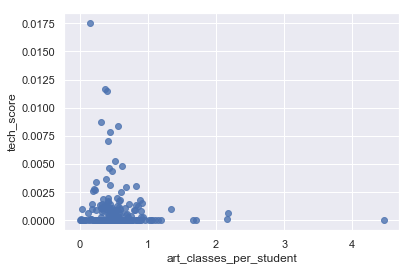

In [4]:

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.regplot(x="art_classes_per_student", y="tech_score", data=d, fit_reg=False)
plt.show()

It looks like the most techy schools aren't particularly artsy, and the most artsy schools aren't particularly techy.

Let's force a more even distribution and identify which schools are highest ranked on both scores.

In [5]:
d['artsy_score'] = d['art_classes_per_student'].rank()/len(d)
d['techy_score'] = d['tech_score'].rank()/len(d)

d['steam_score'] = d['artsy_score']* d['techy_score']

print("here are the top 10 schools with the most tech-related language in their wikis:")
print(d[['cde_school_cde','steam_score']].sort_values('steam_score',ascending=False).head(10))

here are the top 10 schools with the most tech-related language in their wikis:
                                         cde_school_cde  steam_score
565   Crenshaw Science, Technology, Engineering, Mat...     0.800717
1570          School for the Visual Arts and Humanities     0.794554
413                 Valley Academy of Arts and Sciences     0.789502
2217                                    Da Vinci Design     0.754967
1055                                      Edgewood High     0.744774
1651                             University Senior High     0.737820
359   Ramon C. Cortines School of Visual and Performing     0.725081
199                                       Millikan High     0.725014
1195                     International Polytechnic High     0.707761
1211                                      Eastside High     0.696872


### Evaluating Impact on Outcomes

Selena identified 2016-2017 graduation data that we incorporated into our analysis to view how STEAM scores might correlate with school success.  We connect data on `cde_cds_code`, a unique identifier provided to each school.

In [6]:
# import the graduation data
grads = pd.read_csv('data/16-17-grads-cds-csv.csv')

# select and rename key columns
grads = grads[['Row Labels','Sum of GRADS']]
grads.columns = ['cde_cds_code','graduates']

# exclude total row
grads = grads[:-1]

# set cde_cds_code as int
grads['cde_cds_code'] = grads['cde_cds_code'].astype(int)

# import the senior class size data
seniors = pd.read_csv('data/16-17-school-12grade-enrollment.csv')
seniors.columns = ['cde_cds_code','county','seniors']

# exclude total row
seniors = seniors[:-1]

# group senior count by cds code
seniors = seniors.groupby('cde_cds_code').sum()

# set cde_cds_code as index for joining
grads = grads.set_index('cde_cds_code')

# join grad class size and senior class side
grads = grads.join(seniors, how='inner')

# calculate grad rate
grads['grad_rate'] = grads['graduates']/grads['seniors']

# if the grad rate is above 100%, set it to be 100%
# (note: unsure why this happens, and it happens a lot; need to research data further)
grads.loc[grads['grad_rate']>1,'grad_rate'] = 1

# prepare main dataset for join
d['cde_cds_code'] = d['cde_cds_code'].astype(int)
d = d.set_index('cde_cds_code')

combined = d.join(grads,how='left')

print("here are the top 10 schools by graduation rate:")
print(combined[['cde_school_cde','grad_rate']].sort_values('grad_rate',ascending=False).head(10))

here are the top 10 schools by graduation rate:
                                    cde_school_cde  grad_rate
cde_cds_code                                                 
19753411995752  Redondo Shores High (Continuation)        1.0
19647331930973            Simon Rodia Continuation        1.0
19647331932250    Henry David Thoreau Continuation        1.0
19647331931856                Whitman Continuation        1.0
19647331931971              John Hope Continuation        1.0
19647331931930                         Avalon High        1.0
19647331931690           Independence Continuation        1.0
19647331931997                Odyssey Continuation        1.0
19647331931518       George S. Patton Continuation        1.0
19647331931484                Mission Continuation        1.0


Though there are issues with the data we'd investigate with more time, we can at least use these rough measures to plot out the relationships between our arts metric, our tech metric and our STEAM metric on graduation rate.

                         tech_score  art_classes_per_student  steam_score  \
tech_score                 1.000000                -0.073306     0.231875   
art_classes_per_student   -0.073306                 1.000000     0.530156   
steam_score                0.231875                 0.530156     1.000000   
grad_rate                  0.036696                 0.115267     0.159315   

                         grad_rate  
tech_score                0.036696  
art_classes_per_student   0.115267  
steam_score               0.159315  
grad_rate                 1.000000  


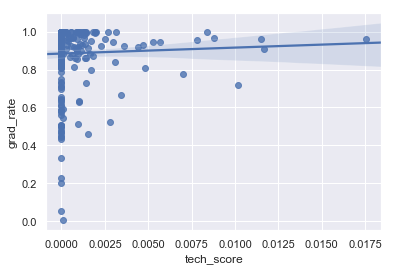

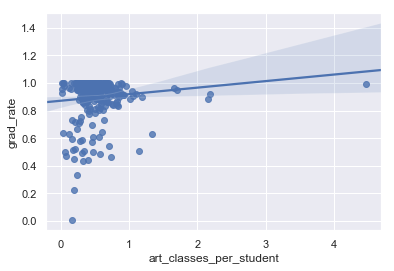

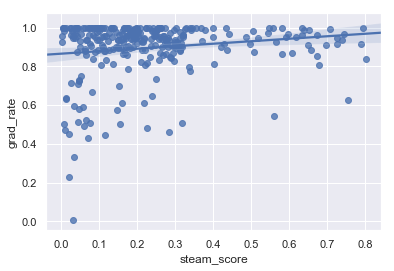

In [7]:
print(combined[['tech_score','art_classes_per_student','steam_score','grad_rate']].corr())

ax = sns.regplot(x="tech_score", y="grad_rate", data=combined)
plt.show()

ax = sns.regplot(x="art_classes_per_student", y="grad_rate", data=combined)
plt.show()

ax = sns.regplot(x="steam_score", y="grad_rate", data=combined)
plt.show()

### Conclusions and Next Steps

Our `steam_score` correlates more with graduation rate (.17) than either `art_classes_per_student` (.11) or `tech_score` (.05) independently, suggesting there may be incremental benefits when both arts and technology share space in the classroom.

Further work building on this analysis could include:
* controlling for confounding factors, like school socio-economic status
* a more specific measure of tech/engineering curriculum
* identifying programs that explicitly integrate arts and technology
* exploration of impact on graduate productivity post-graduation
* investigating the difference between different arts disciplines

All in all, this project was an excellent introduction to the [LA County Arts Ed dataset]('https://www.lacountyartsedcollective.org/profiledata_public'), which is available for others to explore!  There's certainly much more to be gained from working with this and other LA public data, and we look forward to participating again in the LA Arts Datathon next year!

